In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pylab as pylab
import numpy as np
from copy import copy
import os
from PIL import Image
import cv2
from skimage import io
from skimage import color
from skimage.feature import canny
from skimage.filters import sobel
import time

In [29]:
def preProcess(img_path, shape):
    # Read and Copy Image for Writing
    img = readResize(img_path, shape)
    
    # Flip to face breast towards right
    newIm = flipImage(img)
    
    # Background Removal
    newIm = backgroundRemoval(newIm)
    
    # Bar Removal
    newIm = barRemover(newIm, 200)
    finIm = copy(newIm)

    # Pectoral Muscle Removal
    if  "CC" not in img_path:
        canNum = 6
        loop = True
        while loop == True:
            if canNum <= 0:
                finIm = copy(newIm)
                loop = False
            else:
                with np.warnings.catch_warnings():
                    np.warnings.filterwarnings('error')
                    try:
                        finIm = cropPecCanny(newIm, 7, canNum)
                        break
                    except np.RankWarning:
                        canNum -= 1
                    except TypeError:
                        canNum -= 1
                    except cutError:
                        canNum -= 1
        
    return finIm
        

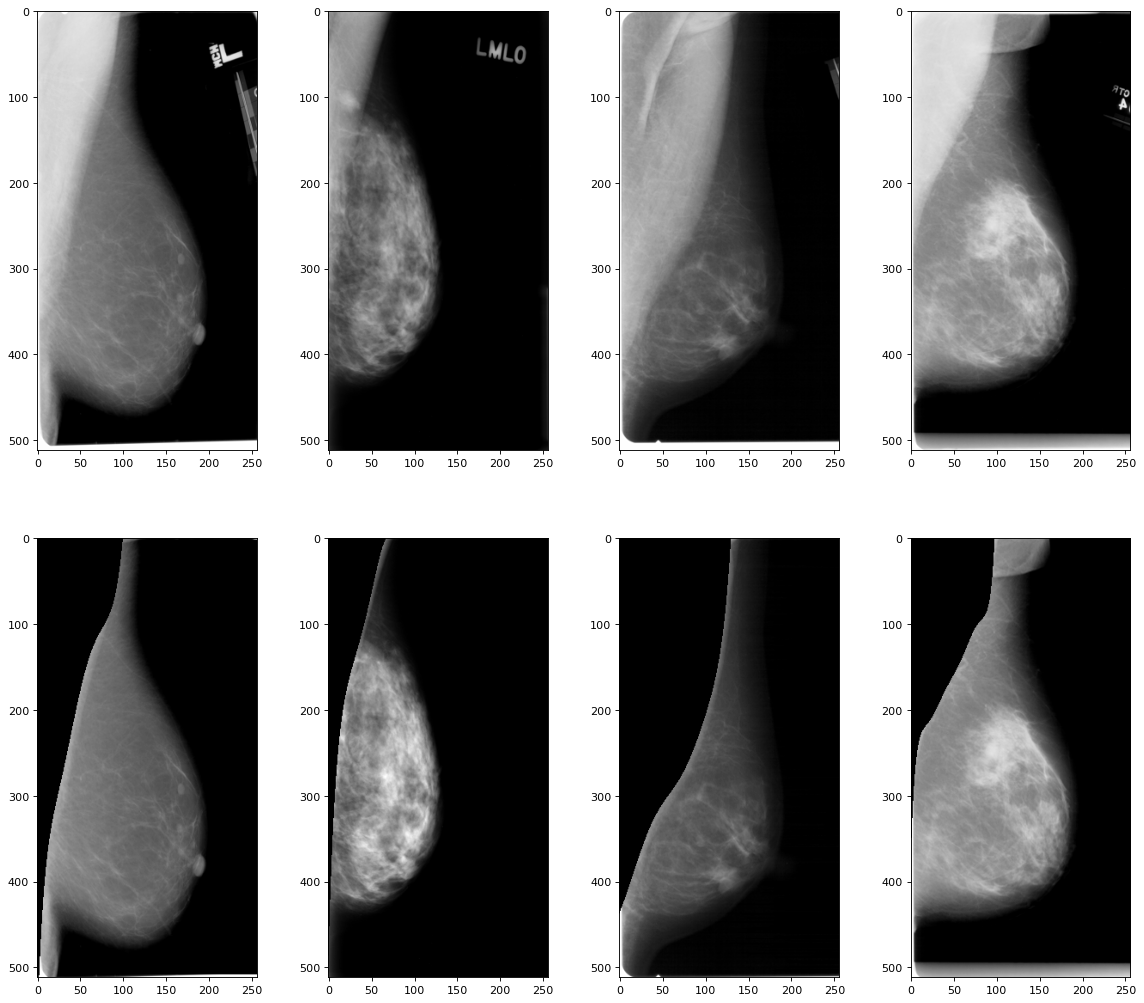

In [35]:
fname = ['Mass-Test_P_00099_LEFT_MLO', 'Mass-Test_P_00114_LEFT_MLO','Mass-Test_P_00126_RIGHT_MLO','Mass-Test_P_00203_LEFT_MLO']
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(len(fname)):
    ogIm = flipImage(readResize("D:/DDSM_Data/DDSM_Mass/Train/Benign/" + fname[i] + ".jpg", (256,512)))
    img = preProcess("D:/DDSM_Data/DDSM_Mass/Train/Benign/" + fname[i] + ".jpg", (256,512))
    plt.subplot(2,4,i+1)
    plt.imshow(ogIm,cmap='gray')
    plt.subplot(2,4,i+5)
    plt.imshow(img, cmap='gray')


In [18]:
def cropPecCanny(img, degree=3, cannyNum=3):
    newIm = copy(img)
    finIm = copy(img)
    newIm = Image.fromarray(newIm)
    newIm = newIm.resize((128,256))
    newIm = np.array(newIm)
    
    cannyIm = canny(newIm, cannyNum)
    cannyIm = Image.fromarray(cannyIm)
    cannyIm = cannyIm.resize((img.shape[1],img.shape[0]))
    cannyIm = np.array(cannyIm)
        
    coords = []
    y = []
    checkCount = 0
    check = False
    for row in range(cannyIm.shape[0]):
        if check == True:
            checkCount += 1
        else:
            checkCount = 0
        if checkCount > 10:
            coords.append(0)
            y.append(row)
        else:
            for col in range(cannyIm.shape[1]):
                if cannyIm[row][col] == True and col > 5:
                    coords.append(col)
                    y.append(row)
                    check = False
                    break
                else:
                    check = True

    y.reverse()
    
    merge = []
    for i in range(len(y)):
        merge.append([y[i], coords[i]])
      
    i = 0
    
    while i < len(merge):
        cond1 = merge[i][1] <= cannyIm.shape[1]/40 # Pixel not in first 10 cols
        cond2 = merge[i][1] >= cannyIm.shape[1]*60/100 # Pixel not in last 60% cols
        cond3 = merge[i][0] < cannyIm.shape[0]/5 # Pixel not in last 1/3rd
        #cond4 = i > 0 and merge[i][1] > (merge[i-1][1] + cannyIm.shape[1]/12) #Pixel not more than 1/12th col size from last pixel
        cond4 = i > 0 and merge[i][1] > merge[i-1][1]
        cond5 = merge[i][0] > cannyIm.shape[0] - cannyIm.shape[0]/5 and  merge[i][1] <= cannyIm.shape[1]/4 # Not in top left corner
        cond6 = i > 0 and merge[i][0] < (merge[i-1][0] - cannyIm.shape[0]/8)
        
        if cond1 or \
            cond2 or \
            cond3 or \
            cond4 or \
            cond6:
                merge.pop(i)
        else:
            i += 1
        
    x_n = []
    y_n = []

    for ind in range(len(merge)):
        x_n.append(merge[ind][1])
        y_n.append(merge[ind][0])
        
    coeffs = np.polyfit(x_n,y_n,degree)
    poly = np.poly1d(coeffs)
    
    new_x = np.linspace(0,cannyIm.shape[1],cannyIm.shape[1])
    new_y = poly(new_x).round(0)
    
    for col in range(img.shape[1]):
        for row in range(img.shape[0]):
            if row < img.shape[0] - new_y[col] and col <= max(x_n):
                finIm[row][col] = 0
                
    cutPoints = []
    bot = min(new_y, key=lambda x:abs(x-0))
    top = min(new_y, key=lambda x:abs(x-img.shape[0]))
    botNum = new_x[np.where(new_y==bot)][0]
    topNum = new_x[np.where(new_y==top)][0]
                   
    #print(botNum, topNum)
                
    if abs(botNum - topNum) < finIm.shape[1]/10:
        raise cutError            
    
    """fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')    
    plt.subplot(1,4,4)
    plt.imshow(finIm, cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(cannyIm, cmap='gray')
    plt.subplot(1,4,3)
    plt.plot(coords, y, 'o')
    plt.axis('scaled')
    plt.ylim(0,cannyIm.shape[0])
    plt.xlim(0,cannyIm.shape[1])
    plt.plot(x_n, y_n, 'o', new_x, new_y)
    plt.axis('scaled')
    plt.ylim(0,cannyIm.shape[0])
    plt.xlim(0,cannyIm.shape[1])
    plt.subplot(1,4,1)
    plt.imshow(newIm, cmap='gray')
    plt.show(fig)"""
    
    return finIm

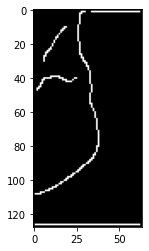

In [16]:
fname = "Mass-Test_P_00718_RIGHT_MLO"
img = readResize("D:/DDSM_Data/DDSM_Mass/Train/Benign/" + fname + ".jpg", (64,128))
newIm = flipImage(img)
newIm = backgroundRemoval(newIm)
newIm = barRemover(newIm, 200)
cannyIm = canny(newIm,3)
plt.imshow(cannyIm, cmap='gray')

In [4]:
class cutError(Exception):
    pass

In [5]:
def readResize(img_path, shape):
    img = plt.imread(img_path)
    img = Image.fromarray(img)
    img = img.resize(shape)
    img = np.array(img)
    
    return img

In [6]:
def flipImage(img):
    leftCount = []
    rightCount = []
    for row in range(img.shape[0]):
        leftCount.append(img[row][0:int(img.shape[1]/2)])
        rightCount.append(img[row][int(img.shape[1]/2):img.shape[1]-1])
    left = np.mean(leftCount)
    right = np.mean(rightCount)
    if right > left:
        img = np.fliplr(img)
    
    return img

In [7]:
def backgroundRemoval(img):
    for row in range(img.shape[0]):
        black = False
        for col in range(img.shape[1]):
            if black == True:
                img[row][col] = 0
            elif img[row][col] == 0 and col > img.shape[1]/2:
                black = True
    
    return img

In [8]:
def barRemover(img, intensity):
    newIm = copy(img)
    row = 0
    while row < newIm.shape[0]:
        if np.mean(newIm[row]) >= intensity:
            newIm = np.delete(newIm, row, 0)
        else:
            row += 1
    
    
    reIm = Image.fromarray(newIm)
    reIm = reIm.resize((img.shape[1], img.shape[0]))
    newIm = np.array(reIm)
    
    return newIm

In [9]:
def cropPecMask(img, degree, shedNum):
    mask = copy(img)
    pecMaskFilter(mask, shedNum)
    maskOutlineFit(mask, img, degree)

In [10]:
def pecMaskFilter(img, shed):
    for i in range(shed):
        threshold = findThresh(img)
        thresh(img,threshold)
    isolatePec(img)
    makeMask(img)
    

In [11]:
def findThresh(img):
    # find normalized_histogram, and its cumulative distribution function
    hist = cv2.calcHist([img],[0],None,[256],[1,256])
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()
    bins = np.arange(256)

    fn_min = np.inf
    threshol = -1
    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        b1,b2 = np.hsplit(bins,[i]) # weights

        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            threshol = i
    
    return threshol

In [12]:
def thresh(img, thresh):
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if img[row][col] < thresh:
                img[row][col] = 0

In [13]:
def isolatePec(img):
    for row in range(img.shape[0]):
        black = False
        for col in range(img.shape[1]):
            if black == True:
                img[row][col] = 0
            elif img[row][col] == 0:
                black = True
            

In [14]:
def makeMask(img):
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if img[row][col] != 0:
                img[row][col] = 255

In [15]:
def maskOutlineFit(mask, img, degree):
    coords = []
    y = []
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row][col] == 0:
                coords.append(col)
                y.append(row)
                break

    y.reverse()
    
    merge = []
    for i in range(len(y)):
        merge.append([y[i], coords[i]])
        
    i = 0
    while i < len(merge):
        # Check for:
        # Pixel not in first 5 cols
        # Pixel not in last 60% of columns
        # Pixel not in last quarter rows
        # Pixel not in first 1/50th
        if merge[i][1] <= 4 or \
        merge[i][1] >= mask.shape[1]*60/100 or \
        merge[i][0] < mask.shape[0]/4 or \
        merge[i][0] > mask.shape[0] - mask.shape[0]/25:
            merge.pop(i)
        else:
            i += 1
    
    x_n = []
    y_n = []

    for ind in range(len(merge)):
        x_n.append(merge[ind][1])
        y_n.append(merge[ind][0])
        
    coeffs = np.polyfit(x_n,y_n,degree)
    poly = np.poly1d(coeffs)
    
    new_x = np.linspace(0,mask.shape[1],mask.shape[1])
    new_y = poly(new_x).round(0)
    
    plt.plot(x_n, y_n, 'o', new_x, new_y)
    plt.ylim(0,mask.shape[0])
    plt.xlim(0,mask.shape[1])
    plt.show()
    
    for col in range(img.shape[1]):
        for row in range(img.shape[0]):
            if row < img.shape[0] - new_y[col] and col <= max(x_n):
                img[row][col] = 0
                

In [37]:
dirB1 = 'D:/DDSM_Data/DDSM_Mass/Train/Benign/'
dirB2 = 'D:/DDSM_Data/DDSM_Hole/Train/Benign/'
dirM1 = 'D:/DDSM_Data/DDSM_Mass/Train/Malignant/'
dirM2 = 'D:/DDSM_Data/DDSM_Hole/Train/Malignant/'

In [38]:
for pathName in os.listdir(dirB1):
    img = preProcess(dirB1 + pathName, (128,256))
    plt.imsave(dirB2 + pathName, img, cmap="gray")

In [39]:
for pathName in os.listdir(dirM1):
    img = preProcess(dirM1 + pathName, (128,256))
    img = makeHoleIm(img)
    plt.imsave(dirM2 + pathName, img, cmap="gray")

In [40]:
print(len(os.listdir(dirB1)),len(os.listdir(dirB2)))

845 845


In [41]:
print(len(os.listdir(dirM1)),len(os.listdir(dirM2)))

739 739


In [16]:
def makeHoleIm(img):
    newIm = copy(img)
    #h,w = newIm.shape
    #mask = np.full((h,w), 255, np.uint8)
    cv2.circle(newIm, (int(newIm.shape[1]*4/9)+np.random.randint(-10,10),int(newIm.shape[0]/2)+np.random.randint(-10,10)), 5, 200, 1)
    #newIm = cv2.bitwise_and(newIm, newIm, mask= mask)
    
    return newIm

In [19]:
"""dirName = 'D:/DDSM_Data/DDSM_Full/Train/Calc_Ben/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Train/Calc_Ben/' + pathName, img, cmap="gray")

dirName = 'D:/DDSM_Data/DDSM_Full/Train/Calc_Mal/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Train/Calc_Mal/' + pathName, img, cmap="gray")
    

dirName = 'D:/DDSM_Data/DDSM_Full/Train/Mass_Ben/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Train/Mass_Ben/' + pathName, img, cmap="gray")

dirName = 'D:/DDSM_Data/DDSM_Full/Train/Mass_Mal/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Train/Mass_Mal/' + pathName, img, cmap="gray")

    
    
    
dirName = 'D:/DDSM_Data/DDSM_Full/Test/Calc_Ben/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Test/Calc_Ben/' + pathName, img, cmap="gray")
    """
dirName = 'D:/DDSM_Data/DDSM_Full/Test/Calc_Mal/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Test/Calc_Mal/' + pathName, img, cmap="gray")
    

dirName = 'D:/DDSM_Data/DDSM_Full/Test/Mass_Ben/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Test/Mass_Ben/' + pathName, img, cmap="gray")
    
dirName = 'D:/DDSM_Data/DDSM_Full/Test/Mass_Mal/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, (256,512))
    plt.imsave('D:/DDSM_Data/DDSM_FullCrop/Test/Mass_Mal/' + pathName, img, cmap="gray")